In [49]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tabulate import tabulate


from trainer import Trainer, generate_data_iter
import utils
import attack
import cam

In [50]:
model_mode, dataset, seed, cuda = 'resnet18', 'FashionMNIST', 2, 0
target_layer = 'layer4' if model_mode == 'resnet18' else 'blocks'
fig_num = 100
metrics = {}

utils.set_random_seed(seed)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)
trainer.load()
scorecam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)

import os
metric_pth = f'./thesis/attack_metrics/{dataset}/'
if not os.path.exists(metric_pth):
    os.makedirs(metric_pth)
    
attack_pth = f'./thesis/attack_pics/{dataset}/'
if not os.path.exists(attack_pth):
    os.makedirs(attack_pth)


# Generate Test data
test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))
raw_cam_nps, raw_preds, _, __ = scorecam(imgs, metric = False)

# Extract Successful Results
suc_indices = raw_preds == labels
suc_imgs, suc_labels = imgs[suc_indices], labels[suc_indices]
suc_cams, suc_saliency_maps, suc_preds, suc_probs, suc_cam_metrics \
    = scorecam(suc_imgs, metric = True, saliency = True)


metrics['Raw'] = {
    'time': 0,
    'success_rate': 1,
    'delta_norm': 0,
    'Average Incr': suc_cam_metrics['Average Incr'], 
    'Average Drop': suc_cam_metrics['Average Drop'],
    'Insertion':  suc_cam_metrics['Insertion'], 
    'Deletion': suc_cam_metrics['Deletion'],
    'saliency_diff': 0,
    'shift_dist': 0
}
print(tabulate(
    list(metrics['Raw'].items()), tablefmt ='orgtbl'
))

| time          | 0           |
| success_rate  | 1           |
| delta_norm    | 0           |
| Average Incr  | 0.315789    |
| Average Drop  | 0.000228414 |
| Insertion     | 0.595607    |
| Deletion      | 0.375929    |
| saliency_diff | 0           |
| shift_dist    | 0           |


In [51]:
def test_advatt(att, max_iter: int = None, att_kwargs: dict = {}):
    start = time.time()
    att_imgs = att(
        suc_imgs, suc_labels, max_iter = max_iter, 
        num_classes = 10, attack_kwargs = att_kwargs
    )
    finish = time.time()
    deltas = att_imgs - suc_imgs
    
    att_preds, _ = scorecam.model_predict(scorecam.tfm(att_imgs))
    
    # Success Rate
    indices = att_preds != suc_labels
    success_rate = indices.sum() / len(att_preds)

    # delta norm
    delta_norm = torch.mean(
        torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
            / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
    )
    
    # In cam part, we only focus on successful part
    att_suc_cams, att_suc_saliency, _, __, att_suc_cam_metrics \
        = scorecam(att_imgs[indices], metric = True, saliency = True)

    # delta saliency map norm
    saliency_diff = np.linalg.norm(
        att_suc_saliency - suc_saliency_maps[indices.numpy()],
        axis = (1, 2)
    ).mean()

    # maximum shift
    size = imgs.shape[-1]
    suc_max_idx_raw = np.argmax(
        suc_saliency_maps[indices.numpy()].reshape(indices.sum(), -1), axis = 1
    )
    suc_max_x, suc_max_y = suc_max_idx_raw // size, suc_max_idx_raw % size

    att_max_idx_raw = np.argmax(att_suc_saliency.reshape(len(att_suc_saliency), -1), axis = 1)
    att_max_x, att_max_y = att_max_idx_raw // size, suc_max_idx_raw % size
    shift_dist = np.sqrt((att_max_x - suc_max_x)**2 + (att_max_y - suc_max_y)**2).mean()
    
    metrics = {
        'time': finish - start,
        'success_rate': success_rate.item(),
        'delta_norm': delta_norm.item(),
        'Average Incr': att_suc_cam_metrics['Average Incr'], 
        'Average Drop': att_suc_cam_metrics['Average Drop'],
        'Insertion':  att_suc_cam_metrics['Insertion'], 
        'Deletion': att_suc_cam_metrics['Deletion'],
        'saliency_diff': saliency_diff,
        'shift_dist': shift_dist
    }
    att_name = att.__class__.__name__
    np.save(attack_pth + f'{att_name}-{dataset}-{model_mode}-seed{seed}.npy', att_imgs.numpy())
    return att_imgs, att_suc_cams, indices.numpy(), metrics

def plot_imgs(
    raw_img: torch.Tensor,
    att_img: torch.Tensor,
    suc_cam: np.ndarray,
    att_cam: np.ndarray
):
    fig = plt.figure(figsize = (12, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(np.transpose(raw_img.numpy(), (1, 2, 0)))
    plt.title('Raw')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.transpose(att_img.numpy(), (1, 2, 0)))
    plt.title('Attack')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(suc_cam)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(att_cam)
    plt.axis('off')

### FGSM

In [52]:
att = attack.FGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.03}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:00<00:00, 124.34it/s]


| time          | 0.765623  |
| success_rate  | 0.368421  |
| delta_norm    | 0.0664125 |
| Average Incr  | 0.4       |
| Average Drop  | 0.0672338 |
| Insertion     | 0.402334  |
| Deletion      | 0.207882  |
| saliency_diff | 9.56763   |
| shift_dist    | 6.17143   |


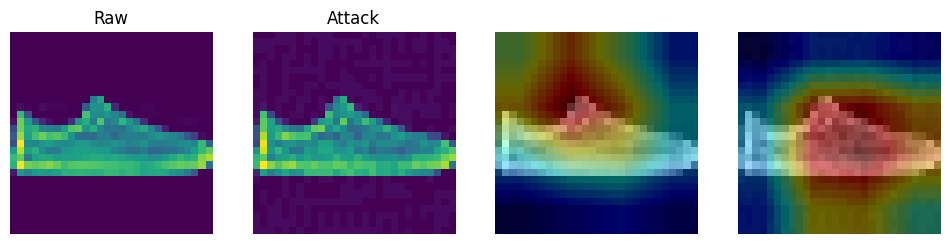

In [53]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### FGM

In [54]:
att = attack.FGM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.8}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:00<00:00, 134.47it/s]


| time          | 0.709311  |
| success_rate  | 0.357895  |
| delta_norm    | 0.0660786 |
| Average Incr  | 0.352941  |
| Average Drop  | 0.0485388 |
| Insertion     | 0.358589  |
| Deletion      | 0.196645  |
| saliency_diff | 8.97405   |
| shift_dist    | 5.97059   |


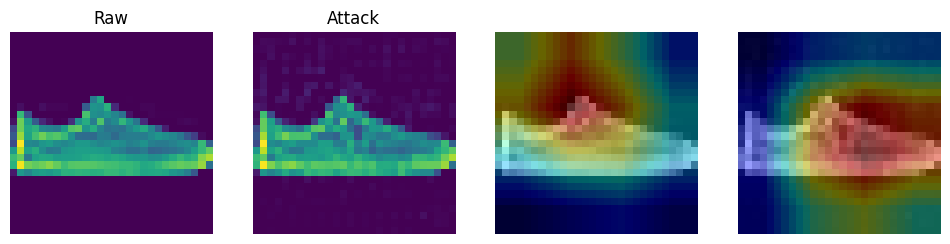

In [55]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Step-LL

In [56]:
att = attack.StepLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.035}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:01<00:00, 81.00it/s]


| time          | 1.17489   |
| success_rate  | 0.347368  |
| delta_norm    | 0.0775184 |
| Average Incr  | 0.69697   |
| Average Drop  | 0.0992594 |
| Insertion     | 0.321354  |
| Deletion      | 0.177695  |
| saliency_diff | 9.34688   |
| shift_dist    | 5.93939   |


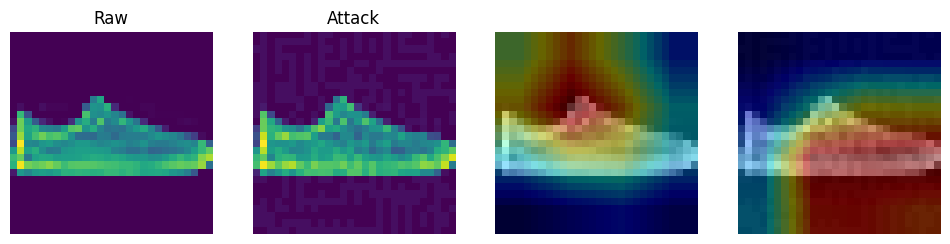

In [57]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### I-FGSM

In [58]:
att = attack.IFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.015}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 12.73it/s]


| time          | 7.46714   |
| success_rate  | 0.978947  |
| delta_norm    | 0.0625902 |
| Average Incr  | 0.0107527 |
| Average Drop  | 0.311288  |
| Insertion     | 0.461784  |
| Deletion      | 0.254372  |
| saliency_diff | 8.4473    |
| shift_dist    | 5.17204   |


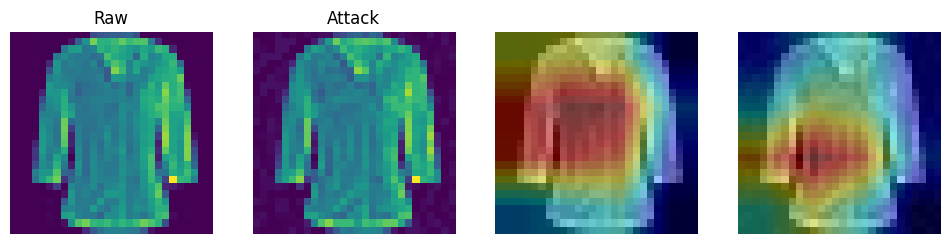

In [59]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### MI-FGSM

In [60]:
att = attack.MIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.015}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 13.06it/s]


| time          | 7.27655   |
| success_rate  | 0.989474  |
| delta_norm    | 0.0637876 |
| Average Incr  | 0         |
| Average Drop  | 0.3122    |
| Insertion     | 0.450331  |
| Deletion      | 0.25922   |
| saliency_diff | 8.48764   |
| shift_dist    | 4.96809   |


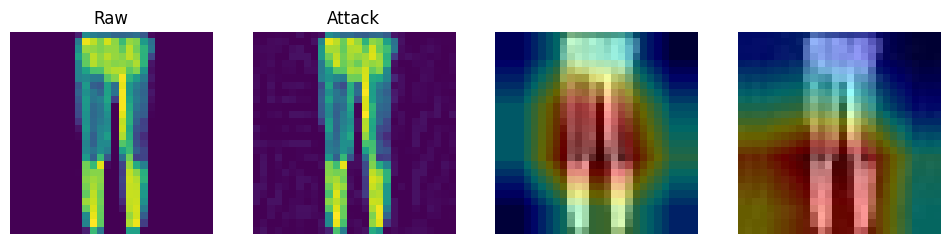

In [61]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### NIFGSM

In [62]:
att = attack.NIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.015}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 12.93it/s]


| time          | 7.34929   |
| success_rate  | 0.989474  |
| delta_norm    | 0.0637837 |
| Average Incr  | 0.0106383 |
| Average Drop  | 0.305618  |
| Insertion     | 0.459376  |
| Deletion      | 0.258114  |
| saliency_diff | 8.61229   |
| shift_dist    | 5.19149   |


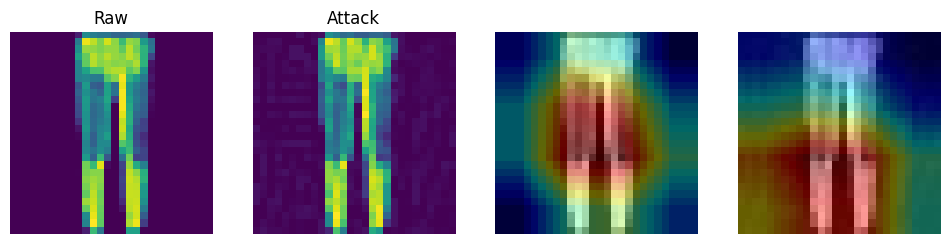

In [63]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### PGD

In [64]:
att = attack.PGD(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.035}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 12.54it/s]


| time          | 7.57641   |
| success_rate  | 1         |
| delta_norm    | 0.0636266 |
| Average Incr  | 0.0210526 |
| Average Drop  | 0.313847  |
| Insertion     | 0.44742   |
| Deletion      | 0.264341  |
| saliency_diff | 8.17184   |
| shift_dist    | 5.15789   |


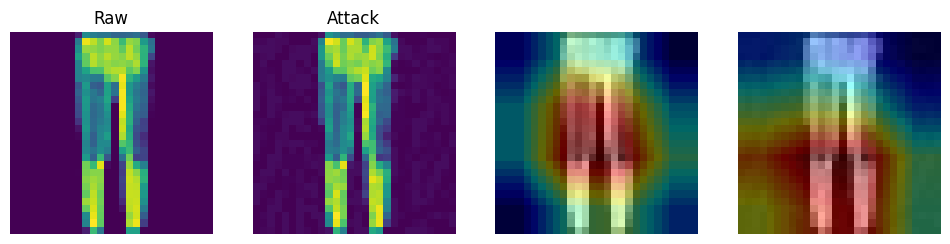

In [65]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

## IterLL

In [66]:
att = attack.IterLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.012}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 12.11it/s]


| time          | 7.8492    |
| success_rate  | 0.778947  |
| delta_norm    | 0.0503917 |
| Average Incr  | 0.148649  |
| Average Drop  | 0.598824  |
| Insertion     | 0.311466  |
| Deletion      | 0.098884  |
| saliency_diff | 9.43601   |
| shift_dist    | 5.75676   |


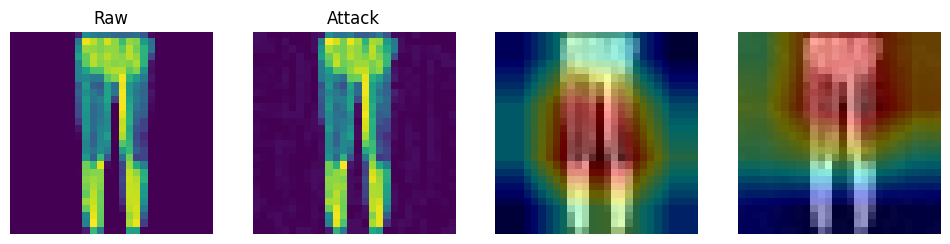

In [67]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Deep Fool

In [68]:
att = attack.DeepFool(trainer.model, cuda)
att_name = att.__class__.__name__
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:05<00:00, 16.62it/s]


| time          | 5.71752  |
| success_rate  | 1        |
| delta_norm    | 0.632254 |
| Average Incr  | 0.473684 |
| Average Drop  | 0.104936 |
| Insertion     | 0.265757 |
| Deletion      | 0.266584 |
| saliency_diff | 8.36514  |
| shift_dist    | 6.70526  |


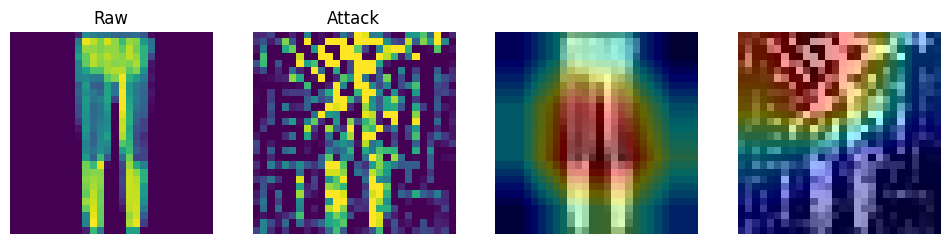

In [69]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### L-BFGS

In [70]:
att = attack.LBFGS(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'c': 0.05}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 100)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [02:45<00:00,  1.74s/it]


| time          | 165.203     |
| success_rate  |   1         |
| delta_norm    |   0.0362659 |
| Average Incr  |   0.031579  |
| Average Drop  |   0.612864  |
| Insertion     |   0.398909  |
| Deletion      |   0.0816381 |
| saliency_diff |  11.1218    |
| shift_dist    |   7.95789   |


In [71]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(metric_pth + f'Attack-{model_mode}-{dataset}-seed{seed}.csv')
metrics_df

,Raw,FGSM,FGM,StepLL,IFGSM,MIFGSM,NIFGSM,PGD,IterLL,DeepFool,LBFGS
time,0.000000,0.765623,0.709311,1.174890,7.467139,7.276545,7.349291,7.576406,7.849200,5.717517,165.202598
success_rate,1.000000,0.368421,0.357895,0.347368,0.978947,0.989474,0.989474,1.000000,0.778947,1.000000,1.000000
delta_norm,0.000000,0.066413,0.066079,0.077518,0.062590,0.063788,0.063784,0.063627,0.050392,0.632254,0.036266
Average Incr,0.315789,0.400000,0.352941,0.696970,0.010753,0.000000,0.010638,0.021053,0.148649,0.473684,0.031579
Average Drop,0.000228,0.067234,0.048539,0.099259,0.311288,0.312200,0.305618,0.313847,0.598824,0.104936,0.612864
Insertion,0.595607,0.402334,0.358589,0.321354,0.461784,0.450331,0.459376,0.447420,0.311466,0.265757,0.398909
Deletion,0.375929,0.207882,0.196645,0.177695,0.254372,0.259220,0.258114,0.264341,0.098884,0.266584,0.081638
saliency_diff,0.000000,9.567628,8.974048,9.346878,8.447305,8.487643,8.612288,8.171844,9.436007,8.365138,11.121839
shift_dist,0.000000,6.171429,5.970588,5.939394,5.172043,4.968085,5.191489,5.157895,5.756757,6.705263,7.957895
